In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm
%matplotlib inline

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False
plt.style.context('Solarize_Light2')

In [35]:
def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_outs(outs):
    return np.power(np.array([np.std(outs[i*512:(i+1)*512]) for i in range(num_temps)]), 2)

num_temps = 100
markers=['.', '^', 'X', 's', '*', 'p']
colors=['blue', 'orange', 'green', 'red', 'm', 'gold']

## Ising on square lattice

$\mathcal{H}=-\sum\limits_{x,y=1}^{L}\left[J_1\sigma_{x,y}\cdot\sigma_{x+1,y}+J_2\sigma_{x,y}\cdot\sigma_{x,y+1}\right]$
 \
 \
$M = \dfrac{J_2}{J_1}$, $J_1 = 1.0$, $J_2 \in [0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]$ \
\
Exact solution: \
\
$\sinh{\dfrac{2J_1}{kT_c}}\cdot\sinh{\dfrac{2J_2}{kT_c}}=1$

In [89]:
roots = [0.3018336135076354, 0.7883671029813581, 0.9723445185469877, 1.2390777517571931, 1.6410179299284857, 1.9728374883141215, 2.2691853142129728, 2.8007227202811613]
ms = [0.0004, 0.0625, 0.125, 0.25, 0.5, 0.75, 1.0, 1.5]
get_crit_T = dict(zip(ms, roots))
Ls = [20, 30, 60, 80, 100]
num_epochs = 3

### Discrete |$T^*$-$T_c$|/$T_c$

$T^* = (T_{max} + T_{min}) / 2$

In [90]:
ts_diff = {}
ts_diff['min'] = []
ts_diff['max'] = []
ts_diff['mean'] = []
ts_diff['T_c'] = []
ts_diff['diff'] = []
ts_diff['ts'] = {M: [] for M in [0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]}

for M in tqdm([0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]):
    T_c = get_crit_T[M]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
    outs_ = []
    
    for i, L in enumerate(Ls):
        with open(f'data_outputs/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_.append(np.squeeze(np.load(f)))

    ts = []
    for i, L in enumerate(Ls):
        # diff = [np.abs(errs(outs_[i][:, 0])[j] - errs(outs_[i][:, 1]))[j] for j in range(num_temps)]
        diff = [np.abs(errs(outs_[i][:, 0])[j] - 0.5) for j in range(num_temps)]
        ts.append(T[np.argmin(diff)])
    ts = np.array(ts)

    # print('min', np.min(ts))
    # print('max', np.max(ts))
    # print('mean', (np.max(ts) + np.min(ts))/ 2)
    # print('T_c', T_c)
    # print('diff', (np.max(ts) + np.min(ts))/ 2 - T_c)

    ts_diff['min'].append(np.min(ts))
    ts_diff['max'].append(np.max(ts))
    ts_diff['mean'].append((np.max(ts) + np.min(ts))/ 2)
    ts_diff['T_c'].append(T_c)
    ts_diff['diff'].append(np.abs((np.max(ts) + np.min(ts))/ 2 - T_c))
    ts_diff['ts'][M] = ts

100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


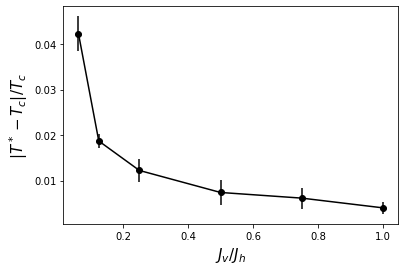

In [91]:
ts_diff_rel = [ts_diff['diff'][i] / ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))]

yerrs = np.array([(np.array(ts_diff['max'][i]) - np.array(ts_diff['mean'][i]))/2/ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))])
plt.errorbar(ms[1:-1], ts_diff_rel, yerr=yerrs, marker='o', color='black')
plt.xlabel('$J_v/J_h$', fontsize=15)
plt.ylabel('$|T^* - T_c|/T_c$', fontsize=15)
# plt.show()
plt.savefig('images/ts_estimate_Jv.png', bbox_inches='tight')

### Estimation of T_c ($T^{\wedge}$) from $\mu$

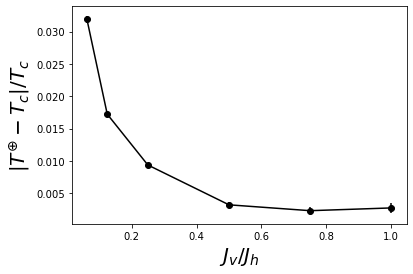

In [92]:
### t_star <--- \mu from L = 100 (J_v/J_h)

t_star = [0.8135, 0.9891, 1.2507, 1.6463, 1.9774, 2.2754]
t_star_diff = [(t_star[i] - ts_diff['T_c'][i]) / ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))]
yerrs = [5e-4, 4e-4, 3e-4, 4e-4, 5e-4, 8e-4]

#yerrs = np.array([(np.array(ts_diff['max'][i]) - np.array(ts_diff['mean'][i]))/2/ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))])
plt.errorbar(ms[1:-1], t_star_diff, yerr=yerrs, marker='o', color='black')
plt.xlabel('$J_v/J_h$', fontsize=20)
plt.ylabel('$|T^{\oplus} - T_c|/T_c$', fontsize=20)
# plt.xlim([0, 1.1])
# plt.ylim([0, 0.05])

# plt.show()
plt.savefig('images/ts_estimate_Jv_mu.png', bbox_inches='tight')

In [40]:
# for M in tqdm([0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]):
#     T_c = get_crit_T[M]
#     T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
#     outs_ = []
    
#     for i, L in enumerate(Ls):
#         with open(f'data_outputs/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
#             outs_.append(np.squeeze(np.load(f)))
#     for i, L in enumerate(Ls):
#         diff_1 = [np.abs(errs(outs_[i][:, 0])[j] - errs(outs_[i][:, 1]))[j] for j in range(num_temps)]
#         diff_2 = [np.abs(errs(outs_[i][:, 0])[j] - 0.5) for j in range(num_temps)]
#         print(T[np.argmin(diff_1)], T[np.argmin(diff_2)])
#         print('\n')

  0%|          | 0/6 [00:00<?, ?it/s]

0.8095792241934794 0.8156398302540855


0.8156398302540855 0.8156398302540855


0.8277610423752977 0.8277610423752977


0.8217004363146916 0.8217004363146916




 17%|█▋        | 1/6 [00:09<00:47,  9.45s/it]

0.8156398302540855 0.8156398302540855


0.999617245819715 0.9935566397591089


0.9935566397591089 0.9935566397591089


0.9935566397591089 0.9935566397591089


0.9935566397591089 0.9935566397591089




 33%|███▎      | 2/6 [00:18<00:37,  9.40s/it]

0.9874960336985028 0.9874960336985028


1.2602898729693144 1.2602898729693144


1.2481686608481022 1.2481686608481022


1.2481686608481022 1.2481686608481022


1.2542292669087083 1.2542292669087083




 50%|█████     | 3/6 [00:28<00:28,  9.41s/it]

1.2481686608481022 1.2481686608481022


1.662230051140607 1.662230051140607


1.6501088390193948 1.6501088390193948


1.6440482329587889 1.6440482329587889


1.6501088390193948 1.6501088390193948




 67%|██████▋   | 4/6 [00:37<00:18,  9.42s/it]

1.6501088390193948 1.6501088390193948


1.9940496095262428 1.9940496095262428


1.9819283974050306 1.9819283974050306


1.9758677913444247 1.9758677913444247


1.9819283974050306 1.9819283974050306




 83%|████████▎ | 5/6 [00:47<00:09,  9.69s/it]

1.9758677913444247 1.9758677913444247


2.284336829364488 2.284336829364488


2.2782762233038816 2.2782762233038816


2.2722156172432757 2.2722156172432757


2.2782762233038816 2.2782762233038816




100%|██████████| 6/6 [00:57<00:00,  9.54s/it]

2.2722156172432757 2.2722156172432757




## Ising on triangular lattice

$\mathcal{H}=-\sum\limits_{x,y=1}^{L}\left[J\sigma_{x,y}(\sigma_{x+1,y}+\sigma_{x,y+1})+J_d \sigma_{x,y}\sigma_{x+1,y+1}\right]$
 \
 \
$J = 1.0$, $J_d \in [-0.7, 0.0]$ with step $0.1$ \
\
Exact solution: \
\
$\left(\sinh{\dfrac{2J}{k_B T_c}}\right)^2+2\sinh{\dfrac{2J}{k_B T_c}}\sinh{\dfrac{2J_d}{k_B T_c}}=1  $

In [84]:
roots = [3.64095690650721,
        3.5184492410503965,
        3.393522159945615,
        3.2659503538230608,
        3.1354715107049764,
        3.0017774197047054,
        2.8645022087095424,
        2.7232065461969945,
        2.577356059664392,
        2.426291319035178,
        2.2691853142129728, 
        2.104982167992544, 
        1.932307699120554,
        1.749339162933206, 
        1.5536238493280832, 
        1.34187327905057, 
        1.109960313758399, 
        0.8541630993606272, 
        0.5762735442012712, 
        0.2885386111960936, 
        0.03198372863548067]
jds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))
num_temps = 100
Jds = jds[10:-1]
Ls = [20, 30, 60, 80]
num_epochs = 3

### Discrete |$T^*$-$T_c$|/$T_c$

$T^* = (T_{max} + T_{min}) / 2$

In [85]:
ts_diff = {}
ts_diff['min'] = []
ts_diff['max'] = []
ts_diff['mean'] = []
ts_diff['T_c'] = []
ts_diff['diff'] = []
ts_diff['ts'] = {Jd: [] for Jd in Jds}

for Jd in tqdm(Jds):
    T_c = get_crit_T[Jd]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
    outs_ = []
    
    for i, L in enumerate(Ls):
        with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_.append(np.squeeze(np.load(f)))

    ts = []
    for i, L in enumerate(Ls):
        # diff = [np.abs(errs(outs_[i][:, 0])[j] - errs(outs_[i][:, 1]))[j] for j in range(num_temps)]
        diff = [np.abs(errs(outs_[i])[j] - 0.5) for j in range(num_temps)]
        ts.append(T[np.argmin(diff)])
    ts = np.array(ts)

    # print('min', np.min(ts))
    # print('max', np.max(ts))
    # print('mean', (np.max(ts) + np.min(ts))/ 2)
    # print('T_c', T_c)
    # print('diff', (np.max(ts) + np.min(ts))/ 2 - T_c)

    ts_diff['min'].append(np.min(ts))
    ts_diff['max'].append(np.max(ts))
    ts_diff['mean'].append((np.max(ts) + np.min(ts))/ 2)
    ts_diff['T_c'].append(T_c)
    ts_diff['diff'].append(np.abs((np.max(ts) + np.min(ts))/ 2 - T_c))
    ts_diff['ts'][Jd] = ts

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


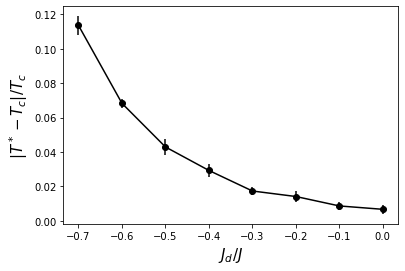

In [86]:
ts_diff_rel = [ts_diff['diff'][i] / ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))]

yerrs = np.array([(np.array(ts_diff['max'][i]) - np.array(ts_diff['mean'][i]))/2/ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))])
plt.errorbar(Jds[:-2], ts_diff_rel[:-2], yerr=yerrs[:-2], marker='o', color='black')
plt.xlabel('$J_d/J$', fontsize=15)
plt.ylabel('$|T^* - T_c|/T_c$', fontsize=15)
# plt.show()
plt.savefig('images/ts_estimate_Jd.png', bbox_inches='tight')

### Estimation of T_c ($T^{\wedge}$) from $\mu$

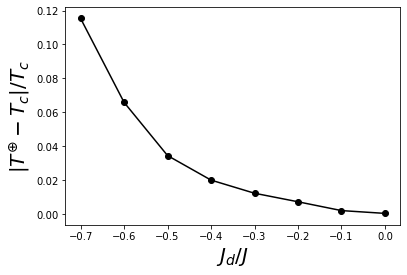

In [87]:
### t_star <--- \mu from L = 100 (J_v/J_h)

mus = [0.9527, 1.1831, 1.3882, 1.5848, 1.7709, 1.9464, 2.1094, 2.2702]
yerrs = [7e-4, 6e-4, 4e-4, 8e-4, 5e-4, 5e-4, 6e-4, 9e-4]
jds = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0]
mus_rel = [(mus[i] - get_crit_T[jds[i]]) / get_crit_T[jds[i]] for i in range(len(jds))]

plt.errorbar(jds, mus_rel, yerr=yerrs, marker='o', color='black')
plt.xlabel('$J_d/J$', fontsize=20)
plt.ylabel('$|T^{\oplus} - T_c|/T_c$', fontsize=20)
# plt.show()
plt.savefig('images/ts_estimate_Jd_mu.png', bbox_inches='tight')

### $J_d > 0$

In [16]:
Jds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

ts_diff = {}
ts_diff['min'] = []
ts_diff['max'] = []
ts_diff['mean'] = []
ts_diff['T_c'] = []
ts_diff['diff'] = []
ts_diff['ts'] = {Jd: [] for Jd in Jds}

for Jd in tqdm(Jds):
    T_c = get_crit_T[Jd]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
    outs_ = []
    
    for i, L in enumerate(Ls):
        with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_.append(np.squeeze(np.load(f)))

    ts = []
    for i, L in enumerate(Ls):
        # diff = [np.abs(errs(outs_[i][:, 0])[j] - errs(outs_[i][:, 1]))[j] for j in range(num_temps)]
        diff = [np.abs(errs(outs_[i])[j] - 0.5) for j in range(num_temps)]
        ts.append(T[np.argmin(diff)])
    ts = np.array(ts)

    # print('min', np.min(ts))
    # print('max', np.max(ts))
    # print('mean', (np.max(ts) + np.min(ts))/ 2)
    # print('T_c', T_c)
    # print('diff', (np.max(ts) + np.min(ts))/ 2 - T_c)

    ts_diff['min'].append(np.min(ts))
    ts_diff['max'].append(np.max(ts))
    ts_diff['mean'].append((np.max(ts) + np.min(ts))/ 2)
    ts_diff['T_c'].append(T_c)
    ts_diff['diff'].append(np.abs(T_c - (np.max(ts) + np.min(ts))/ 2))
    ts_diff['ts'][Jd] = ts

100%|██████████| 9/9 [01:34<00:00, 10.51s/it]


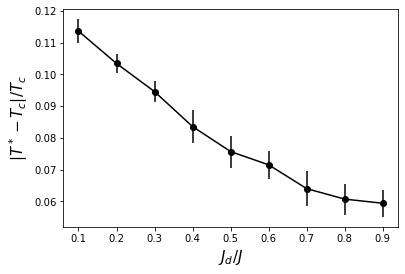

<Figure size 432x288 with 0 Axes>

In [18]:
ts_diff_rel = [ts_diff['diff'][i] / ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))]

yerrs = np.array([(np.array(ts_diff['max'][i]) - np.array(ts_diff['mean'][i]))/2/ts_diff['T_c'][i] for i in range(len(ts_diff['diff']))])
plt.errorbar(Jds, ts_diff_rel, yerr=yerrs, marker='o', color='black')
plt.xlabel('$J_d/J$', fontsize=15)
plt.ylabel('$|T^* - T_c|/T_c$', fontsize=15)
plt.show()
plt.savefig('images/ts_diff_jd_pos.png')

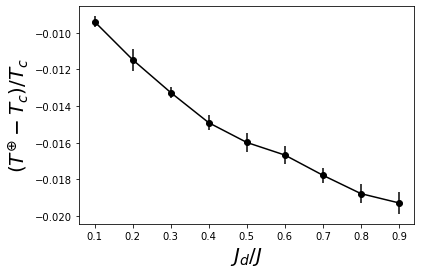

In [19]:
### t_star <--- \mu from L = 80 (J_v/J_h)

mus = [2.4035, 2.5478, 2.6871, 2.8218, 2.9538, 3.0832, 3.2079, 3.3298, 3.4506]
yerrs = [3e-4, 6e-4, 3e-4, 4e-4, 5e-4, 5e-4, 4e-4, 5e-4, 6e-4]
jds = Jds
mus_rel = [(mus[i] - get_crit_T[jds[i]]) / get_crit_T[jds[i]] for i in range(len(jds))]

plt.errorbar(jds, mus_rel, yerr=yerrs, marker='o', color='black')
plt.xlabel('$J_d/J$', fontsize=20)
plt.ylabel('$(T^{\oplus} - T_c)/T_c$', fontsize=20)
# plt.xlim([0, 1.1])
# plt.ylim([0, 0.05])

plt.savefig('images/ts_star_diff_jd_pos.png')

### prepare data

In [60]:
roots = [0.3018336135076354, 0.7883671029813581, 0.9723445185469877, 1.2390777517571931, 1.6410179299284857, 1.9728374883141215, 2.2691853142129728, 2.8007227202811613]
ms = [0.0004, 0.0625, 0.125, 0.25, 0.5, 0.75, 1.0, 1.5]
get_crit_T = dict(zip(ms, roots))
Ls = [20, 30, 60, 80, 100]
num_epochs = 3

for M in tqdm([0.0625, 0.125, 0.25, 0.5, 0.75, 1.0]):
    T_c = get_crit_T[M]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
    
    for i, L in enumerate(Ls):
        with open(f'data_outputs/square/{M}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_ = np.squeeze(np.load(f))
        with open(f'data_temps/square/{M}_{L}.npy', 'wb') as f:
            np.save(f, errs(outs_[:, 0]), allow_pickle=False)

100%|██████████| 6/6 [00:00<00:00, 17.39it/s]


In [61]:
with open(f'data_temps/square/{M}_{L}.npy', 'rb') as f:
    outs = np.load(f)
    print(outs.shape)

(100,)


In [71]:
roots = [3.64095690650721,
        3.5184492410503965,
        3.393522159945615,
        3.2659503538230608,
        3.1354715107049764,
        3.0017774197047054,
        2.8645022087095424,
        2.7232065461969945,
        2.577356059664392,
        2.426291319035178,
        2.2691853142129728, 
        2.104982167992544, 
        1.932307699120554,
        1.749339162933206, 
        1.5536238493280832, 
        1.34187327905057, 
        1.109960313758399, 
        0.8541630993606272, 
        0.5762735442012712, 
        0.2885386111960936, 
        0.03198372863548067]
jds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))
num_temps = 100
# Jds = jds[10:-1]
Jds = jds[1:10]
Ls = [20, 30, 60, 80]
num_epochs = 3

In [72]:
for Jd in tqdm(Jds):
    T_c = get_crit_T[Jd]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)
    
    for i, L in enumerate(Ls):
        with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_ = np.squeeze(np.load(f))
        with open(f'data_temps/triang/{Jd}_{L}.npy', 'wb') as f:
            np.save(f, errs(outs_), allow_pickle=False)

100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


In [66]:
with open(f'data_temps/triang/{Jd}_{L}.npy', 'rb') as f:
    outs = np.load(f)
    print(outs.shape)

(100,)


In [93]:
!zip -r data_outs data_outs/

  adding: data_outs/ (stored 0%)
  adding: data_outs/square_Jv_L/ (stored 0%)
  adding: data_outs/square_Jv_L/0.5_100.npy (deflated 29%)
  adding: data_outs/square_Jv_L/0.25_80.npy (deflated 28%)
  adding: data_outs/square_Jv_L/0.125_100.npy (deflated 28%)
  adding: data_outs/square_Jv_L/0.0625_20.npy (deflated 23%)
  adding: data_outs/square_Jv_L/0.5_80.npy (deflated 27%)
  adding: data_outs/square_Jv_L/1.0_80.npy (deflated 25%)
  adding: data_outs/square_Jv_L/0.125_60.npy (deflated 26%)
  adding: data_outs/square_Jv_L/0.25_30.npy (deflated 20%)
  adding: data_outs/square_Jv_L/0.75_20.npy (deflated 21%)
  adding: data_outs/square_Jv_L/0.75_80.npy (deflated 26%)
  adding: data_outs/square_Jv_L/0.0625_100.npy (deflated 30%)
  adding: data_outs/square_Jv_L/0.75_60.npy (deflated 26%)
  adding: data_outs/square_Jv_L/0.25_60.npy (deflated 28%)
  adding: data_outs/square_Jv_L/0.5_30.npy (deflated 18%)
  adding: data_outs/square_Jv_L/1.0_30.npy (deflated 18%)
  adding: data_outs/square_Jv_L/0